In [1]:
from __future__ import annotations
import numpy as np
import random
from scipy.linalg import block_diag

from matplotlib import pyplot as plt
from numba import jit

In [2]:

class Node:
    def __init__(self, id: int, infected: bool = False):
        self.id = id
        self.infected = infected
        self.neighbors = []

    def add_neighbor(self, neighbor: Node):
        self.neighbors.append(neighbor)

class Graph:
    def __init__(self, size: int):
        self.size = size
        self.nodes = [Node(i, False) for i in range(self.size)]
        self.number_of_edges = 0

    def tick(self):
        pass

    def create_edge(self, node_id1, node_id2):
        assert(node_id1 < self.size and node_id2 < self.size)
        if node_id1 == node_id2:
            return
        if not node_id1 in self.nodes[node_id2].neighbors:
            self.nodes[node_id1].add_neighbor(self.nodes[node_id2])
            self.nodes[node_id2].add_neighbor(self.nodes[node_id1])
            self.number_of_edges += 1
    
class SIModel(Graph):
    def __init__(self, size, infection_prob):
        super().__init__(size)
        self.infection_prob = infection_prob
        self.amount_of_infected = 0

    def infect_node(self, node_id : int):
        self.amount_of_infected += 1
        self.nodes[node_id].infected = True
    
    def try_infecting_neighbors(self, node)->None:
        if not node.infected:
            return
        for neighbor in node.neighbors:
            should_be_infected = np.random.random() < self.infection_prob
            if (not neighbor.infected) and should_be_infected:
                self.infect_node(neighbor.id)
    
    def tick(self)->None:
        node_indices = list(range(len(self.nodes)))
        random.shuffle(node_indices)
        randomized_nodes = [self.nodes[r] for r in node_indices]
        for node in randomized_nodes:
            self.try_infecting_neighbors(node)

    @staticmethod
    def create_from_correlation_matrix(corr_mat: np.matrix, infection_prob: float)->SIModel:
        g = SIModel(int(np.sqrt(corr_mat.size)), infection_prob)
        for i in range(g.size):
            for j in range(i,g.size):
                should_be_connected = np.random.random() < corr_mat[i,j]
                if should_be_connected:
                    g.create_edge(i,j)
        return g

def create_erdos_graph_model(size: int, prob_of_connection: float, prob_of_infection: float)->SIModel:
    g = SIModel(size, prob_of_infection)

    for i in range(g.size):
        for j in range(g.size):
            should_be_connected = np.random.random() < prob_of_connection
            if should_be_connected:
                g.create_edge(i,j)
    return g

def create_correlation_matrix(N: int)->np.matrix:
    prob_10 = 0.1
    prob_100 = 0.01
    prob_1000 = 0.001
    m = np.matrix([[prob_1000 for i in range(N)] for i in range(N)])
    block_100 = np.matrix([[prob_100 for i in range(N//10)] for i in range(N//10)])
    m_100 = block_diag(*([block_100] * (N//100)))
    for i in range(N):
        for j in range(N):
            if(m_100[i,j] > 0):
                m[i,j] = prob_100
    
    block_10 = np.matrix([[prob_10 for i in range(N//100)] for i in range(N//100)])
    m_10 = block_diag(*([block_10] * (N//10)))
    for i in range(N):
        for j in range(N):
            if(m_10[i,j] > 0):
                m[i,j] = prob_10
    return m

def create_simple_correlation_matrix(N: int)->np.matrix:
    prob_max = 0.01
    m = np.matrix([[prob_max - np.sqrt(np.abs(i-j))/N**2 for i in range(N)] for j in range(N)])
    return m




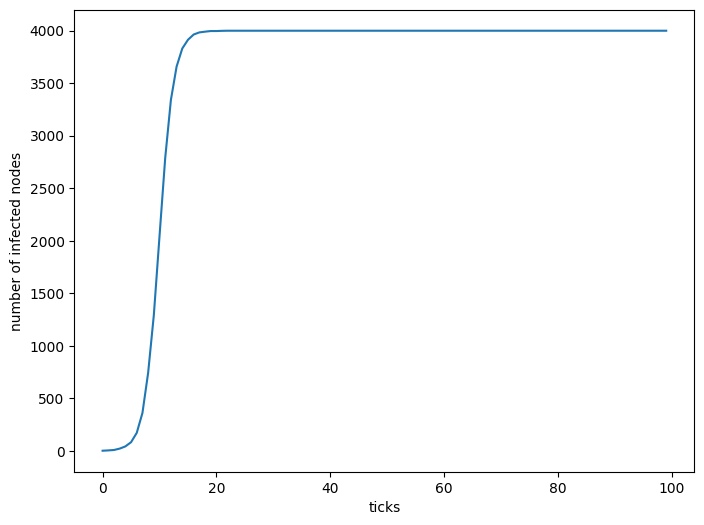

number of nodes:  4000
number of edges:  159316


In [3]:
#create an erdos graph
g = create_erdos_graph_model(4000, 0.01, 0.01)
#infect node 0
g.nodes[0].infected = True

#gather data
tick_numbers = []
infected_at_tick = []

#watch chaos unfold
for i in range(100):
    g.tick()
    tick_numbers.append(i)
    infected_at_tick.append(g.amount_of_infected)    

#plot the sucker
plt.figure(figsize = (8,6))
plt.plot(tick_numbers, infected_at_tick)
plt.xlabel('ticks')
plt.ylabel('number of infected nodes')

# plt.savefig('out/infected_per_tick_erdos.jpg', dpi=300)
plt.show()

print("number of nodes: ", len(g.nodes))
print("number of edges: ", g.number_of_edges)

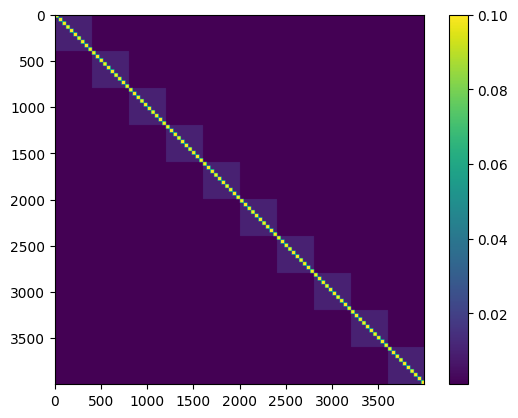

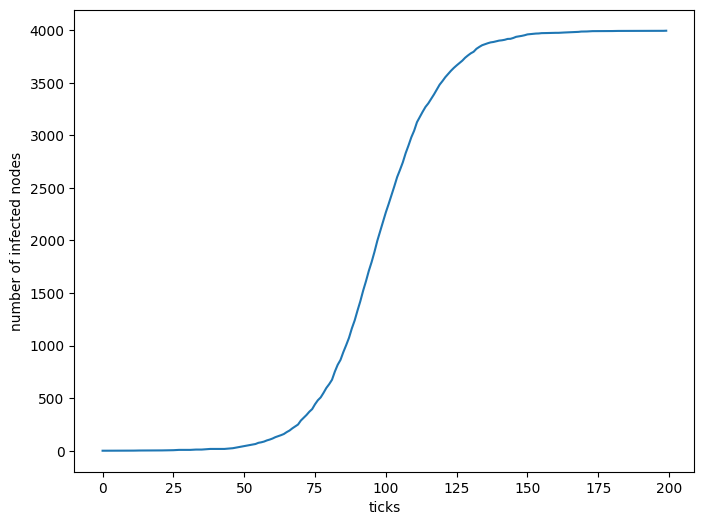

number of nodes:  4000
number of edges:  22332


In [4]:
#create correlation matrix
corr_mat = create_correlation_matrix(4000)

#plot it to see what it looks like
plt.imshow(corr_mat)
plt.colorbar()

# plt.savefig('out/correlation_matrix_visualization.jpg', dpi=300)

plt.show()

#create correlation (probability) matrix
corr_mat = create_correlation_matrix(4000)

#create a model from the matrix
g = SIModel.create_from_correlation_matrix(corr_mat, 0.01)

#set first node to infected
g.nodes[0].infected = True

#gather data
tick_numbers = []
infected_at_tick = []

#watch chaos unfold
for i in range(200):
    g.tick()
    tick_numbers.append(i)
    infected_at_tick.append(g.amount_of_infected)    

#plot the sucker
plt.figure(figsize = (8,6))
plt.plot(tick_numbers, infected_at_tick)
plt.xlabel('ticks')
plt.ylabel('number of infected nodes')

# plt.savefig('out/infected_per_tick_variable_correlation.jpg', dpi=300)

plt.show()

print("number of nodes: ", len(g.nodes))
print("number of edges: ", g.number_of_edges)

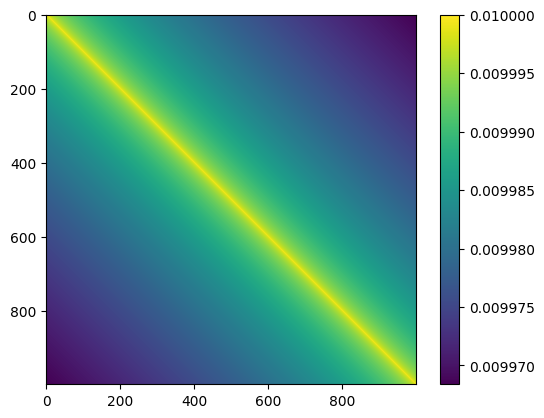

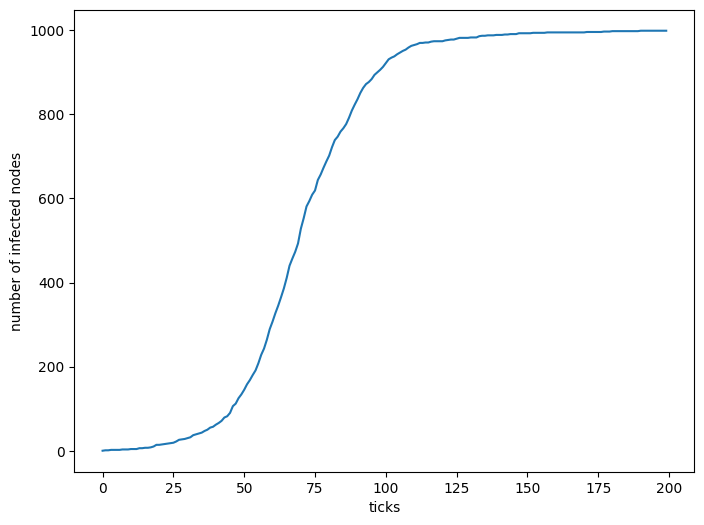

number of nodes:  1000
number of edges:  4954


In [5]:
corr_mat = create_simple_correlation_matrix(1000)
plt.imshow(corr_mat)
plt.colorbar()

# plt.savefig('out/correlation_matrix_visualization.jpg', dpi=300)

plt.show()

#create a model from the matrix
g = SIModel.create_from_correlation_matrix(corr_mat, 0.01)

#set first node to infected
g.nodes[0].infected = True

#gather data
tick_numbers = []
infected_at_tick = []

#watch chaos unfold
for i in range(200):
    g.tick()
    tick_numbers.append(i)
    infected_at_tick.append(g.amount_of_infected)    

#plot the sucker
plt.figure(figsize = (8,6))
plt.plot(tick_numbers, infected_at_tick)
plt.xlabel('ticks')
plt.ylabel('number of infected nodes')

# plt.savefig('out/infected_per_tick_variable_correlation.jpg', dpi=300)

plt.show()

print("number of nodes: ", len(g.nodes))
print("number of edges: ", g.number_of_edges)